## Set-up

In [9]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import random
from tqdm.notebook import tqdm, trange

sns.set_theme()
colors = sns.color_palette("deep")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin
from scipy.spatial.distance import cdist, euclidean
from utils import geometric_median, geometric_medoid

In [10]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [11]:
def initialize_W(X, n_components):
    W = pd.DataFrame(np.random.rand(len(X), n_components), index=X.index, columns=[f"Component {k+1}" for k in range(n_components)])
    W = W.div(W.sum(axis=1), axis=0)
    return W

In [12]:
n_components = 4 # Number of components for the matrix factorization

colormap = ListedColormap([colors[k] for k in range(n_components)])

# Process data

## Data matrix $X$

In [13]:
input_df = pd.read_csv('data/daily_curves_pos_smoothed_13b_15min.csv', index_col=0)
print(len(input_df))
input_df.head(3)

11653


0      0.25       0.5      0.75  \
Calabria_2021-01-02_Saturday     0.036730  0.036109  0.035466  0.034786   
Calabria_2021-01-03_Holiday      0.035047  0.033892  0.032865  0.031954   
Calabria_2021-01-04_Working day  0.031268  0.029670  0.028259  0.027072   

                                        1      1.25       1.5      1.75  \
Calabria_2021-01-02_Saturday     0.034069  0.033328  0.032585  0.031873   
Calabria_2021-01-03_Holiday      0.031142  0.030415  0.029760  0.029169   
Calabria_2021-01-04_Working day  0.026126  0.025422  0.024945  0.024668   

                                        2      2.25  ...     21.75        22  \
Calabria_2021-01-02_Saturday     0.031222  0.030664  ...  0.045978  0.044433   
Calabria_2021-01-03_Holiday      0.028640  0.028179  ...  0.048568  0.047236   
Calabria_2021-01-04_Working day  0.024556  0.024567  ...  0.044802  0.043732   

                                    22.25      22.5     22.75        23  \
Calabria_2021-01-02_Saturday     0.042998  0.041705  0.040570  0.039590   
Calabria_2021-01-03_Holiday      0.045760  0.044178  0.042535  0.040885   
Calabria_2021-01-04_Working day  0.042585  0.041312  0.039884  0.038299   

                                    23.25      23.5     23.75        24  
Calabria_2021-01-02_Saturday     0.038747  0.038013  0.037353  0.036730  
Calabria_2021-01-03_Holiday      0.039276  0.037750  0.036334  0.035047  
Calabria_2021-01-04_Working day  0.036586  0.034797  0.032999  0.031268  

[3 rows x 97 columns]

In [14]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# df = df[df.month.isin(months)]
# df = df[(df.month == '10')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

11653


0      0.25       0.5      0.75  \
Calabria_2021-01-02_Saturday     0.036730  0.036109  0.035466  0.034786   
Calabria_2021-01-03_Holiday      0.035047  0.033892  0.032865  0.031954   
Calabria_2021-01-04_Working day  0.031268  0.029670  0.028259  0.027072   

                                        1      1.25       1.5      1.75  \
Calabria_2021-01-02_Saturday     0.034069  0.033328  0.032585  0.031873   
Calabria_2021-01-03_Holiday      0.031142  0.030415  0.029760  0.029169   
Calabria_2021-01-04_Working day  0.026126  0.025422  0.024945  0.024668   

                                        2      2.25  ...     22.75        23  \
Calabria_2021-01-02_Saturday     0.031222  0.030664  ...  0.040570  0.039590   
Calabria_2021-01-03_Holiday      0.028640  0.028179  ...  0.042535  0.040885   
Calabria_2021-01-04_Working day  0.024556  0.024567  ...  0.039884  0.038299   

                                    23.25      23.5     23.75        24  \
Calabria_2021-01-02_Saturday     0.038747  0.038013  0.037353  0.036730   
Calabria_2021-01-03_Holiday      0.039276  0.037750  0.036334  0.035047   
Calabria_2021-01-04_Working day  0.036586  0.034797  0.032999  0.031268   

                                   region  year  month      daytype  
Calabria_2021-01-02_Saturday     Calabria  2021     01     Saturday  
Calabria_2021-01-03_Holiday      Calabria  2021     01      Holiday  
Calabria_2021-01-04_Working day  Calabria  2021     01  Working day  

[3 rows x 101 columns]

In [15]:
X = df.drop(unit_info.columns, axis=1)
X = X.div(X.sum(axis=1), axis=0)
X.head()

0      0.25       0.5      0.75  \
Calabria_2021-01-02_Saturday     0.009102  0.008948  0.008789  0.008621   
Calabria_2021-01-03_Holiday      0.008690  0.008403  0.008149  0.007923   
Calabria_2021-01-04_Working day  0.007760  0.007364  0.007014  0.006719   
Calabria_2021-01-05_Working day  0.008372  0.008278  0.008191  0.008105   
Calabria_2021-01-06_Holiday      0.008356  0.008071  0.007826  0.007619   

                                        1      1.25       1.5      1.75  \
Calabria_2021-01-02_Saturday     0.008443  0.008259  0.008075  0.007899   
Calabria_2021-01-03_Holiday      0.007722  0.007541  0.007379  0.007232   
Calabria_2021-01-04_Working day  0.006484  0.006309  0.006191  0.006122   
Calabria_2021-01-05_Working day  0.008015  0.007916  0.007810  0.007696   
Calabria_2021-01-06_Holiday      0.007449  0.007312  0.007204  0.007121   

                                        2      2.25  ...     21.75        22  \
Calabria_2021-01-02_Saturday     0.007737  0.007599  ...  0.011394  0.011011   
Calabria_2021-01-03_Holiday      0.007101  0.006987  ...  0.012042  0.011712   
Calabria_2021-01-04_Working day  0.006095  0.006097  ...  0.011119  0.010854   
Calabria_2021-01-05_Working day  0.007578  0.007463  ...  0.010300  0.009981   
Calabria_2021-01-06_Holiday      0.007059  0.007015  ...  0.011414  0.011154   

                                    22.25      22.5     22.75        23  \
Calabria_2021-01-02_Saturday     0.010656  0.010335  0.010054  0.009811   
Calabria_2021-01-03_Holiday      0.011346  0.010954  0.010547  0.010137   
Calabria_2021-01-04_Working day  0.010569  0.010253  0.009899  0.009505   
Calabria_2021-01-05_Working day  0.009681  0.009407  0.009161  0.008946   
Calabria_2021-01-06_Holiday      0.010855  0.010519  0.010157  0.009778   

                                    23.25      23.5     23.75        24  
Calabria_2021-01-02_Saturday     0.009602  0.009420  0.009257  0.009102  
Calabria_2021-01-03_Holiday      0.009738  0.009360  0.009009  0.008690  
Calabria_2021-01-04_Working day  0.009080  0.008636  0.008190  0.007760  
Calabria_2021-01-05_Working day  0.008763  0.008609  0.008481  0.008372  
Calabria_2021-01-06_Holiday      0.009397  0.009025  0.008675  0.008356  

[5 rows x 97 columns]

# NMF

In [16]:
n_runs = 1000
p = len(X.columns)

In [17]:
# Load the arrays from the .npz file
# path = f'data/nmf_results/uniform_{n_components}comp_{n_runs}runs.npz'
path = 'data/nmf_results/uniform_4comp_smoothed_1000runs.npz'
data = np.load(path)
print('Loaded ', path)

Loaded  data/nmf_results/uniform_4comp_smoothed_1000runs.npz


In [18]:
# Access the arrays
H_results = data['H_results']
W_results = data['W_results']
iterations = data['iterations']
errors = data['errors']

## Clean results

In [19]:
# Remove results for which we have less than 100 iterations (they correspond to a local minima where all profile are the same)
H_results = H_results[..., iterations > 100]
W_results = W_results[..., iterations > 100]
errors = errors[iterations > 100]
iterations = iterations[iterations > 100]
print('{} results clean'.format(W_results.shape[2]))

809 results clean


# Results analysis

## K-means clustering to group similar profiles

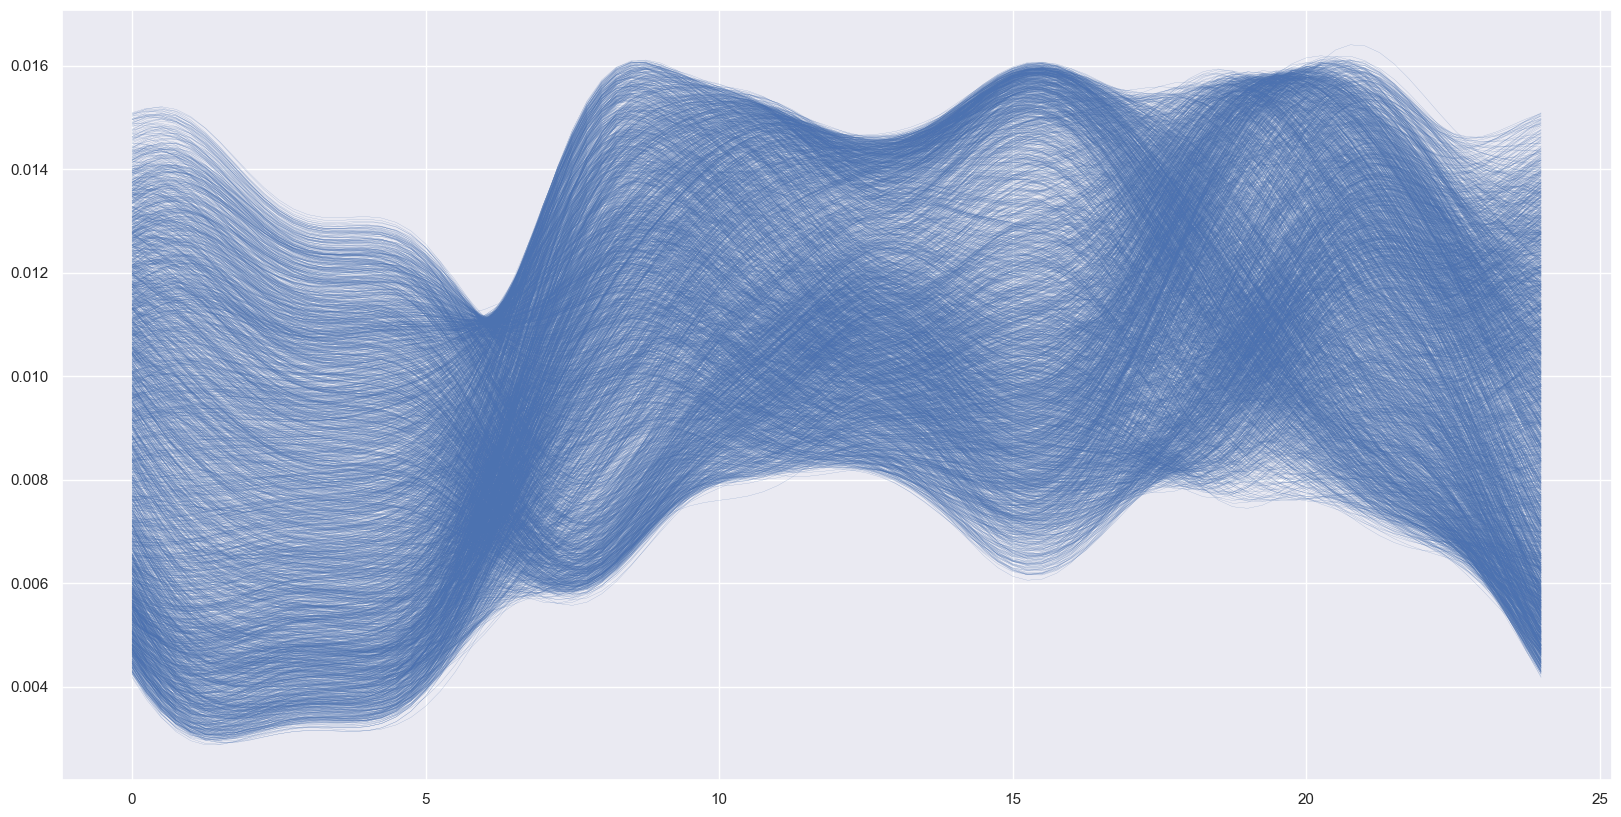

In [32]:
n_clean_runs = W_results.shape[2]
abscissa = [float(x) for x in X.columns]
fig, ax = plt.subplots(figsize=(20, 10))

for i in range(n_clean_runs):
    for k in range(n_components):
        line, = ax.plot(abscissa, H_results[k, :, i], linewidth=0.1, color=colors[0])

In [23]:
H_results_flat = H_results.transpose([0, 2, 1]).reshape((n_components * n_clean_runs, p)) # Flattening the array of profiles
kmeans = KMeans(n_clusters=n_components, n_init=10).fit(H_results_flat)

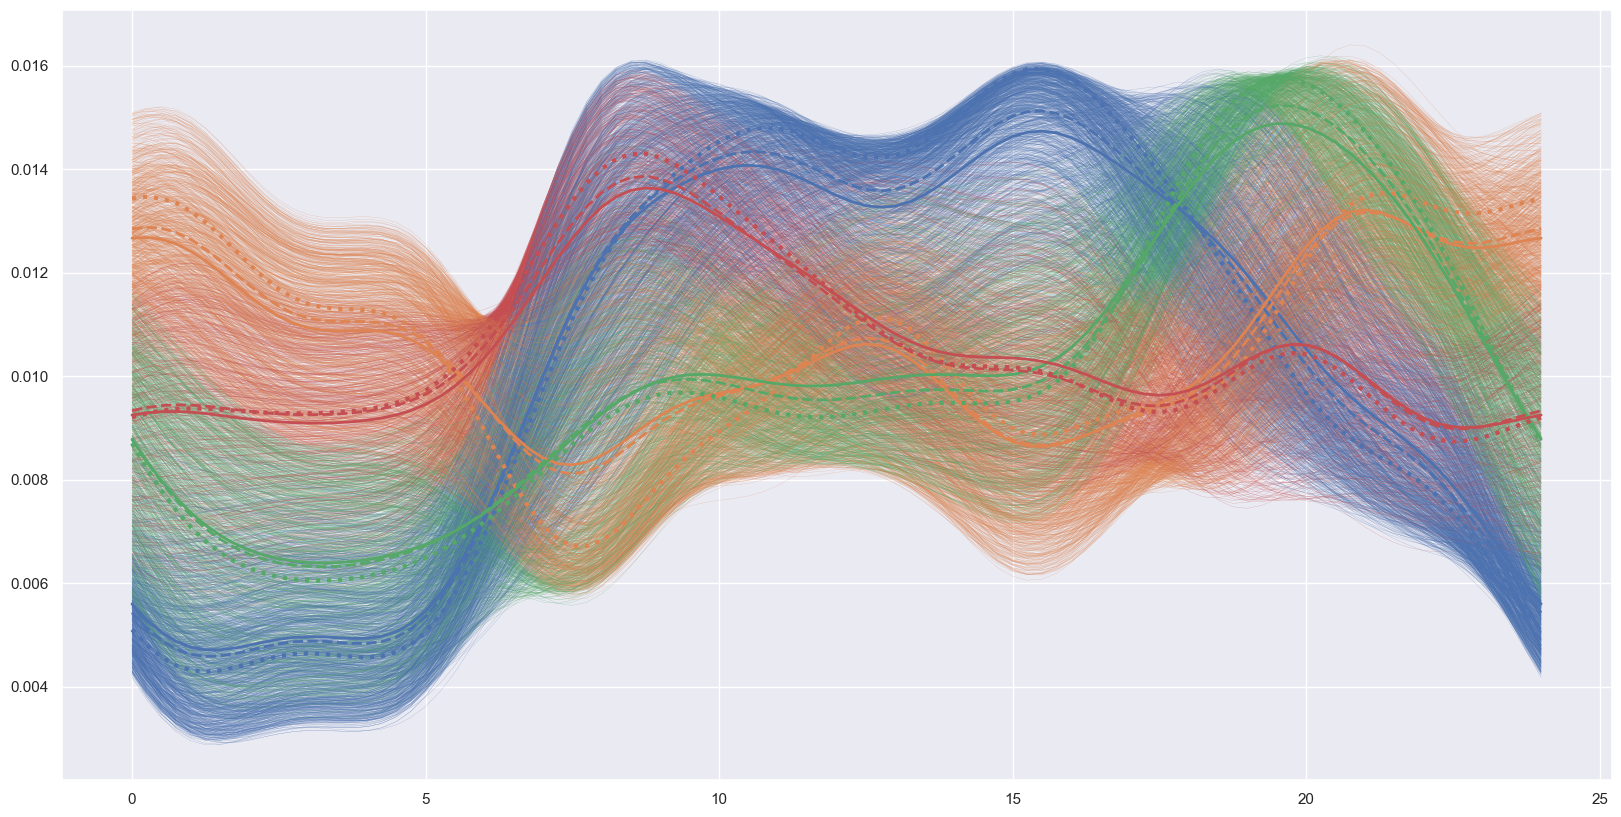

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot each profile curve coloring per cluster
for i in range(n_components * n_clean_runs):
    cluster_label = kmeans.labels_[i]
    ax.plot(abscissa, H_results_flat[i, :], linewidth=0.1, color=colors[cluster_label])

# Plot cluster centroids
for i in range(n_components):
    ax.plot(abscissa, kmeans.cluster_centers_[i, :], linewidth=2, color=colors[i])
    ax.plot(abscissa, geometric_median(H_results_flat[kmeans.labels_ == i, :]), linewidth=2, linestyle='dashed', color=colors[i])
    ax.plot(abscissa, geometric_medoid(H_results_flat[kmeans.labels_ == i, :]), linewidth=3, linestyle='dotted', color=colors[i])
    

In [17]:
# # Export cluster centers
# path = f'data/nmf_results/{n_components}comp_cluster_centers_{n_runs}runs.npy'
# np.save(path, kmeans.cluster_centers_)
# print('Saved', path)

Saved data/nmf_results/5comp_cluster_centers_1000runs.npy


Let's plot per cluster

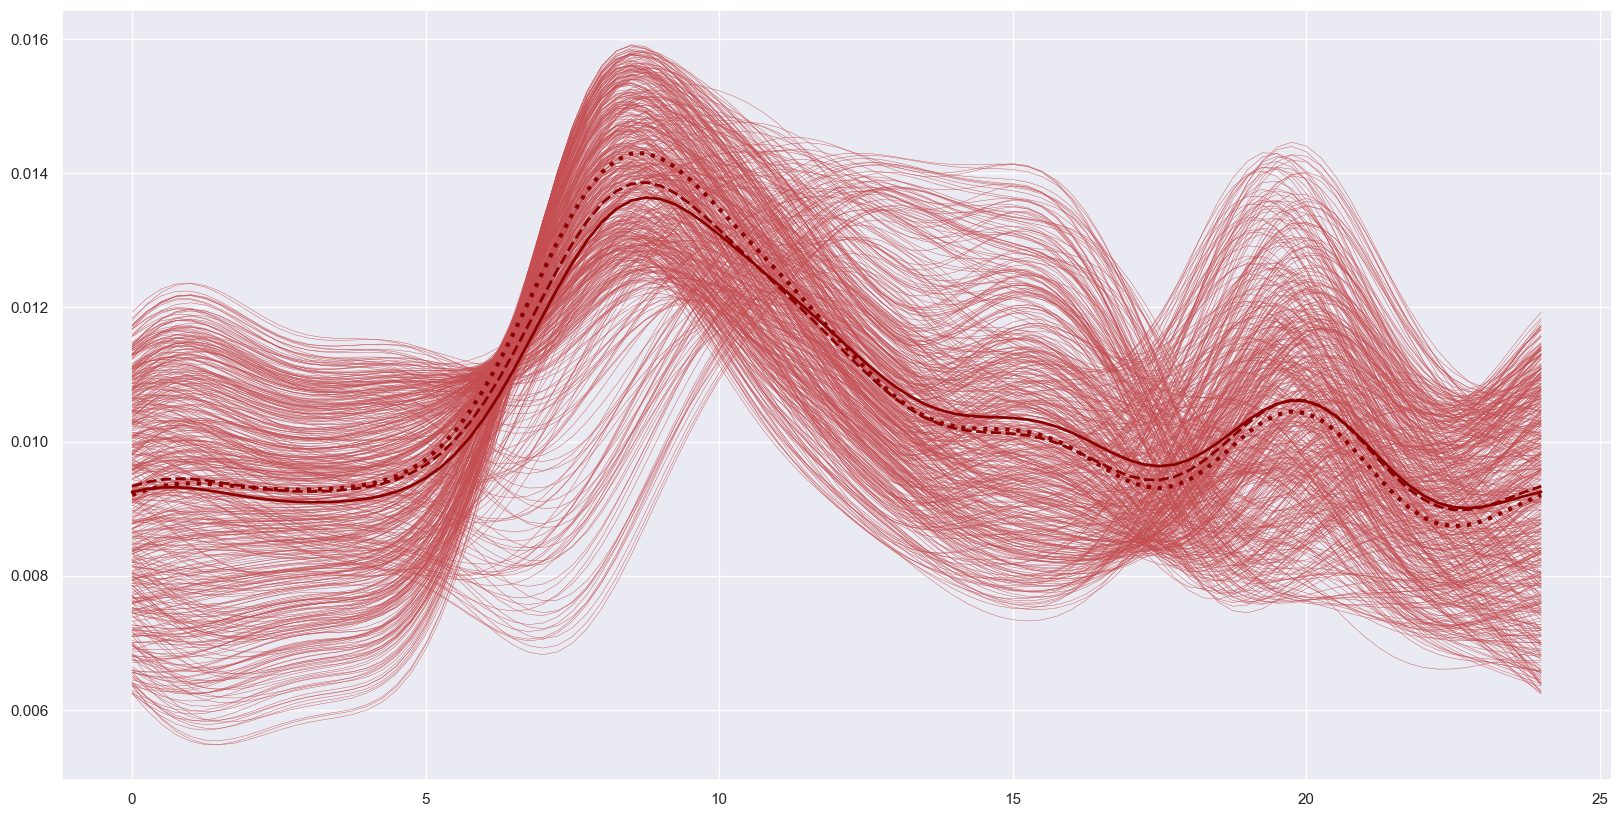

In [34]:
cluster = 3
fig, ax = plt.subplots(figsize=(20, 10))

# Plot each profile curve coloring per cluster
for i in range(n_components * n_clean_runs):
    cluster_label = kmeans.labels_[i]
    if cluster_label == cluster:
        ax.plot(abscissa, H_results_flat[i, :], linewidth=0.3, color=colors[cluster_label])

# Plot cluster centroids
color = 'darkred'
# color = colors[cluster]
ax.plot(abscissa, kmeans.cluster_centers_[cluster, :], linewidth=2, color=color)
ax.plot(abscissa, geometric_median(H_results_flat[kmeans.labels_ == cluster, :]), linewidth=2, linestyle='dashed', color=color)
ax.plot(abscissa, geometric_medoid(H_results_flat[kmeans.labels_ == cluster, :]), linewidth=3, linestyle='dotted', color=color)
# ax.set_ylim((0,0.05))

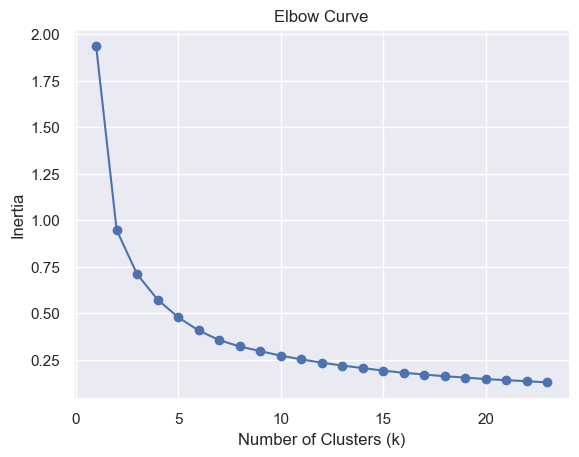

In [35]:
# Seems that there are more than 4 clusters of profiles. Let's try to find how much:

# Calculate inertia for different values of k
inertias = []
k_values = range(1, 24)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(H_results_flat)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

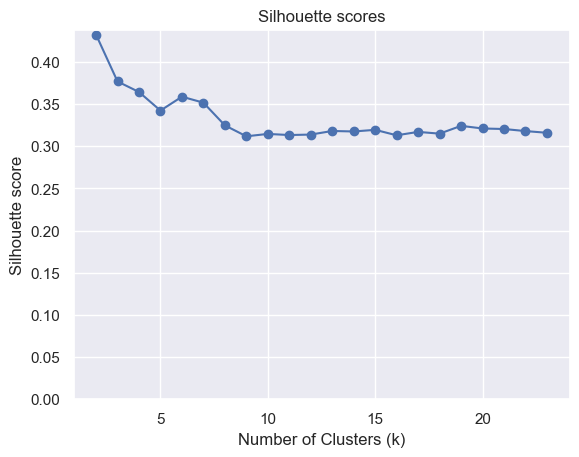

In [36]:
# Calculate silhouette score for different values of k
silhouette_scores = []
k_values = range(2, 24)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(H_results_flat)
    labels = kmeans.labels_
    score = silhouette_score(H_results_flat, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores')
plt.ylim(bottom=0)
plt.show()

<Axes: >

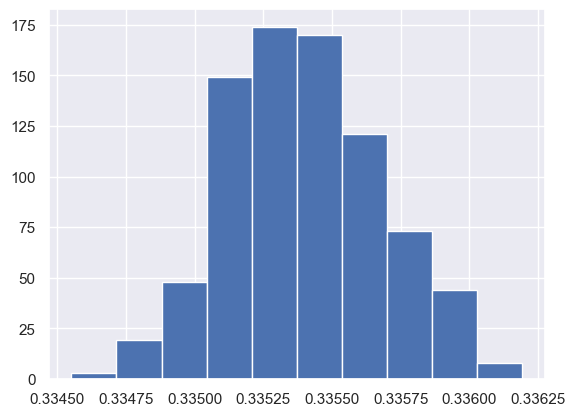

In [38]:
pd.Series(errors).hist()

## Select the solution that is compliant to the physics of the problem

### Cyclic profiles

We want to find solutions for which
$$\text{discontinuity}(H) = \sum_{k=1}^K(H_k(p) - H_k(1))^2$$

In [39]:
H_discontinuity = ((H_results[:, 0, :] - H_results[:, p-1, :])**2).sum(axis=0)

<Axes: >

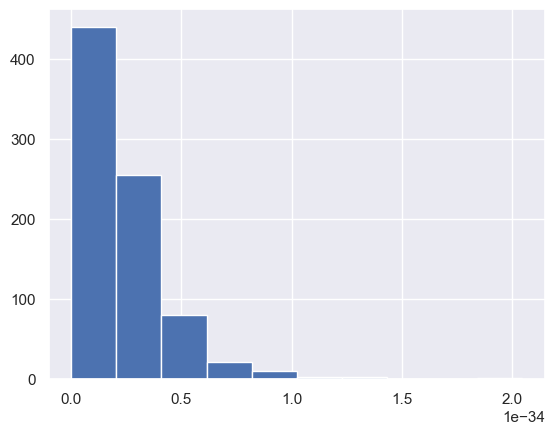

In [40]:
pd.Series(H_discontinuity).hist()

### Total distance of concentration vectors to simplex

The distance to the simplex of one observation $x$ to the simplex $\mathcal{S}(n)$ is the following
$$\text{dist}(x, \mathcal{S}(n)) = \inf_{\substack{y \in \mathcal{S}(n)}} d(x, y)$$

The point $y$ minimizing the distance is:
$$y = \frac{x}{||x||_1}$$

Here we will compute the sum of the distances to the simplex for all vector of concentrations of the matrix $W$

In [41]:
W_proj_simplex = W_results / W_results.sum(axis=1)[:, np.newaxis, :]
W_dist_simplex = np.sqrt(((W_results - W_proj_simplex)**2).sum(axis=1))
W_sum_dist_simplex = W_dist_simplex.sum(axis=0)

<Axes: >

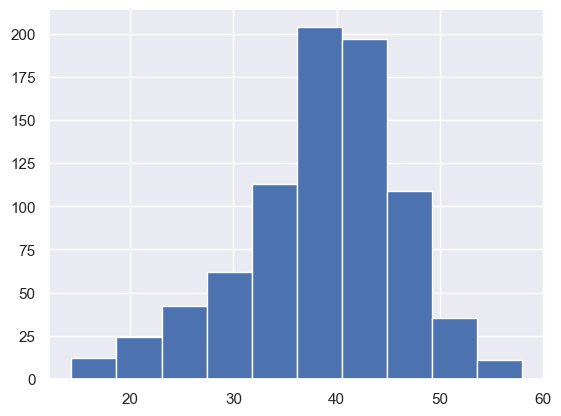

In [42]:
pd.Series(W_sum_dist_simplex).hist()

### Scatterplot of the value of the two constraints

In [43]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=H_discontinuity,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex',
    yaxis_title='Discontinuity of the profiles',
    title='Compliance of solutions with physics of the system',
    height=1500,
    width=1500
)

# # Show the plot
# fig.show()

In [44]:
best_run = 23

H = H_results[..., best_run]
W = W_results[..., best_run]

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Components found by the NMF'}, xlabel='Hour', ylabel='Load (MW)'>)

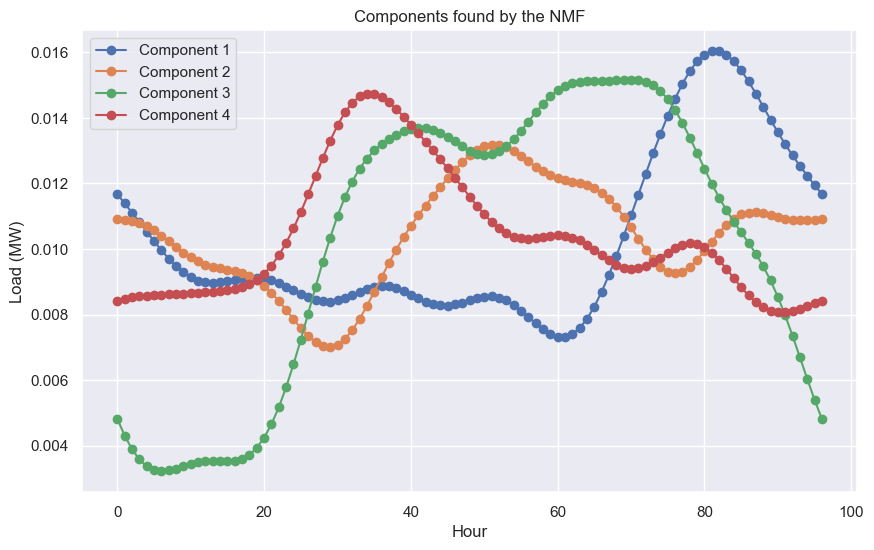

In [45]:
plot_components(H)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Components found by the NMF'}, xlabel='Hour', ylabel='Load (MW)'>)

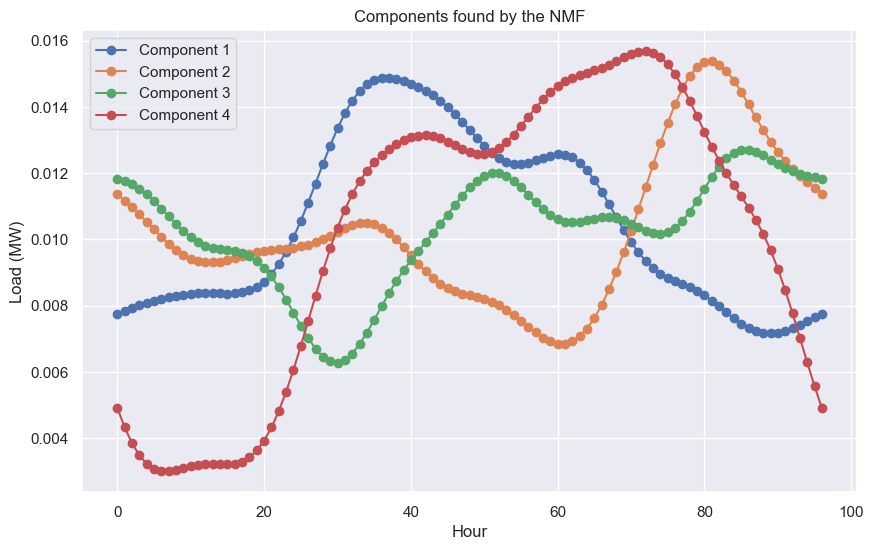

In [55]:
# plot_components(H_results[...,random.randint(0, H_results.shape[2]-1)])
plot_components(H_results[...,614])

In [56]:
W = pd.DataFrame(W, index=df.index, columns=[f"Component {k+1}" for k in range(n_components)])
W[unit_info.columns] = df[unit_info.columns]
W

Component 1  Component 2  Component 3  \
Calabria_2021-01-02_Saturday        0.416517     0.199111     0.325524   
Calabria_2021-01-03_Holiday         0.341279     0.270270     0.394639   
Calabria_2021-01-04_Working day     0.250312     0.106106     0.515788   
Calabria_2021-01-05_Working day     0.257725     0.077005     0.331606   
Calabria_2021-01-06_Holiday         0.230927     0.338077     0.407579   
...                                      ...          ...          ...   
South_2022-12-27_Working day        0.329004     0.027523     0.549651   
South_2022-12-28_Working day        0.190402     0.087505     0.740635   
South_2022-12-29_Working day        0.244576     0.198453     0.316880   
South_2022-12-30_Working day        0.456389     0.000417     0.551185   
South_2022-12-31_Saturday           0.233925     0.165956     0.212541   

                                  Component 4    region  year month  \
Calabria_2021-01-02_Saturday     6.218116e-02  Calabria  2021    01   
Calabria_2021-01-03_Holiday      8.157805e-05  Calabria  2021    01   
Calabria_2021-01-04_Working day  1.360396e-01  Calabria  2021    01   
Calabria_2021-01-05_Working day  3.368685e-01  Calabria  2021    01   
Calabria_2021-01-06_Holiday      2.739638e-02  Calabria  2021    01   
...                                       ...       ...   ...   ...   
South_2022-12-27_Working day     1.017840e-01     South  2022    12   
South_2022-12-28_Working day     1.011035e-13     South  2022    12   
South_2022-12-29_Working day     2.424342e-01     South  2022    12   
South_2022-12-30_Working day     3.212326e-03     South  2022    12   
South_2022-12-31_Saturday        3.873997e-01     South  2022    12   

                                     daytype  
Calabria_2021-01-02_Saturday        Saturday  
Calabria_2021-01-03_Holiday          Holiday  
Calabria_2021-01-04_Working day  Working day  
Calabria_2021-01-05_Working day  Working day  
Calabria_2021-01-06_Holiday          Holiday  
...                                      ...  
South_2022-12-27_Working day     Working day  
South_2022-12-28_Working day     Working day  
South_2022-12-29_Working day     Working day  
South_2022-12-30_Working day     Working day  
South_2022-12-31_Saturday           Saturday  

[11653 rows x 8 columns]

In [57]:
W[(W.region == 'North')&(W.daytype == 'Working day')].sort_index().tail(20)

Component 1  Component 2  Component 3  \
North_2022-12-01_Working day     0.093226     0.175214     0.333152   
North_2022-12-02_Working day     0.051316     0.216387     0.307117   
North_2022-12-05_Working day     0.040354     0.159754     0.481280   
North_2022-12-06_Working day     0.103199     0.167740     0.322431   
North_2022-12-07_Working day     0.086628     0.166355     0.313383   
North_2022-12-09_Working day     0.098271     0.198186     0.394358   
North_2022-12-12_Working day     0.049682     0.147517     0.481025   
North_2022-12-13_Working day     0.019450     0.229249     0.345819   
North_2022-12-14_Working day     0.042581     0.214913     0.320582   
North_2022-12-15_Working day     0.011485     0.254995     0.350610   
North_2022-12-16_Working day     0.002049     0.236040     0.313023   
North_2022-12-19_Working day     0.035274     0.147307     0.446682   
North_2022-12-20_Working day     0.041878     0.207604     0.335802   
North_2022-12-21_Working day     0.034568     0.193624     0.343157   
North_2022-12-22_Working day     0.032000     0.180790     0.330497   
North_2022-12-23_Working day     0.022236     0.176464     0.264605   
North_2022-12-27_Working day     0.167790     0.114017     0.457956   
North_2022-12-28_Working day     0.171927     0.102116     0.424368   
North_2022-12-29_Working day     0.167112     0.135680     0.360789   
North_2022-12-30_Working day     0.203103     0.125269     0.372611   

                              Component 4 region  year month      daytype  
North_2022-12-01_Working day     0.398480  North  2022    12  Working day  
North_2022-12-02_Working day     0.424058  North  2022    12  Working day  
North_2022-12-05_Working day     0.321605  North  2022    12  Working day  
North_2022-12-06_Working day     0.406494  North  2022    12  Working day  
North_2022-12-07_Working day     0.432748  North  2022    12  Working day  
North_2022-12-09_Working day     0.311091  North  2022    12  Working day  
North_2022-12-12_Working day     0.325146  North  2022    12  Working day  
North_2022-12-13_Working day     0.404998  North  2022    12  Working day  
North_2022-12-14_Working day     0.421492  North  2022    12  Working day  
North_2022-12-15_Working day     0.382020  North  2022    12  Working day  
North_2022-12-16_Working day     0.448131  North  2022    12  Working day  
North_2022-12-19_Working day     0.372796  North  2022    12  Working day  
North_2022-12-20_Working day     0.414290  North  2022    12  Working day  
North_2022-12-21_Working day     0.428469  North  2022    12  Working day  
North_2022-12-22_Working day     0.456585  North  2022    12  Working day  
North_2022-12-23_Working day     0.535607  North  2022    12  Working day  
North_2022-12-27_Working day     0.264030  North  2022    12  Working day  
North_2022-12-28_Working day     0.305165  North  2022    12  Working day  
North_2022-12-29_Working day     0.337926  North  2022    12  Working day  
North_2022-12-30_Working day     0.301163  North  2022    12  Working day

In [58]:
W_region = W.groupby('region')[[f"Component {k+1}" for k in range(n_components)]].sum()
W_region = W_region.div(W_region.sum(axis=1), axis=0)
W_region

Component 1  Component 2  Component 3  Component 4
region                                                          
Calabria         0.303523     0.219394     0.280634     0.196449
Centre.North     0.153525     0.274163     0.306401     0.265910
Centre.South     0.253773     0.267265     0.316922     0.162040
North            0.155437     0.238496     0.282087     0.323979
Sardinia         0.263044     0.249273     0.160616     0.327066
Sicily           0.336735     0.238604     0.225344     0.199317
South            0.298575     0.234175     0.230111     0.237139

Text(0, 0.5, '')

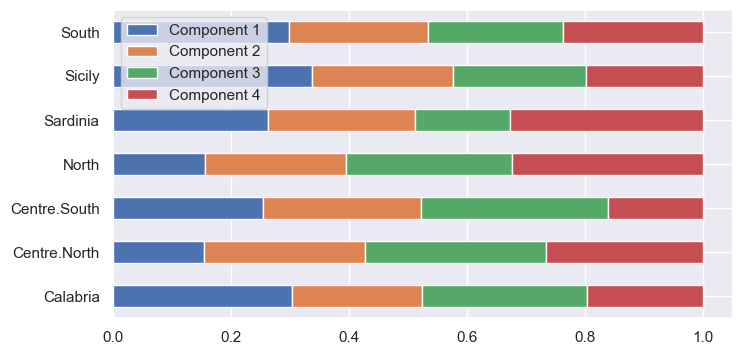

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
W_region.plot.barh(stacked=True, ax=ax)
ax.set_ylabel("")

<Axes: xlabel='component', ylabel='concentration'>

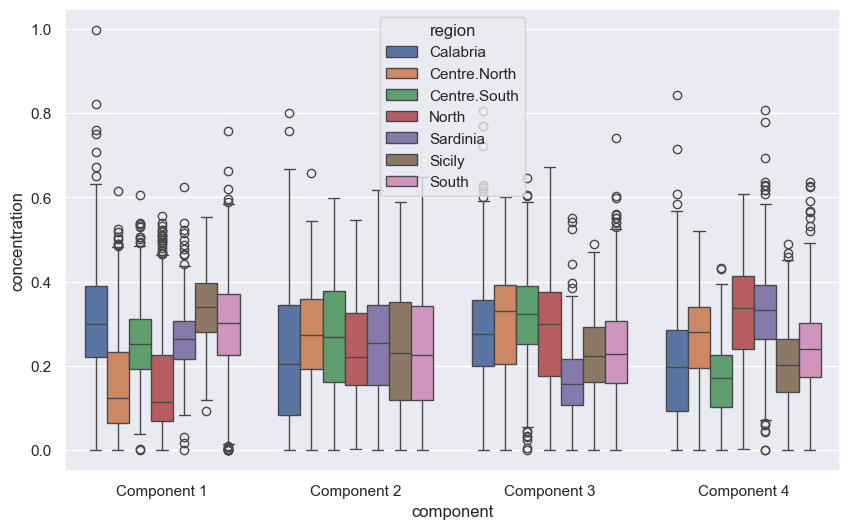

In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='component',
    y='concentration',
    hue='region',
)

<Axes: xlabel='month', ylabel='concentration'>

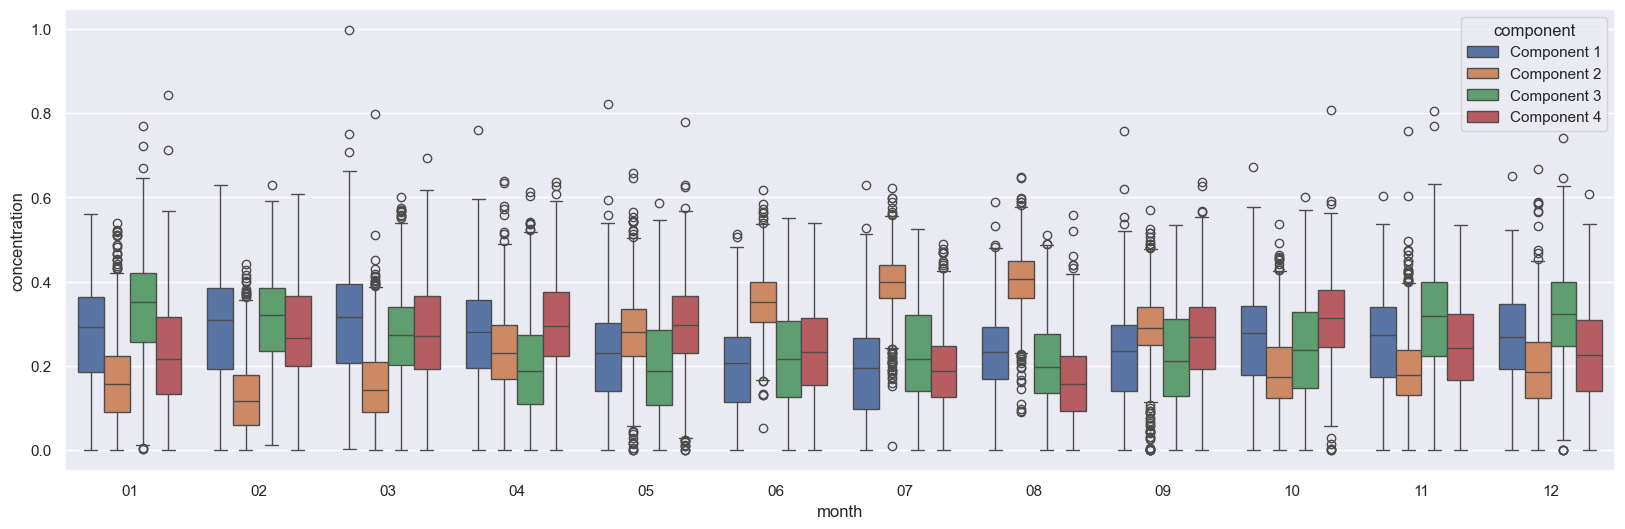

In [61]:
plt.figure(figsize=(20,6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
)

<Axes: xlabel='month', ylabel='concentration'>

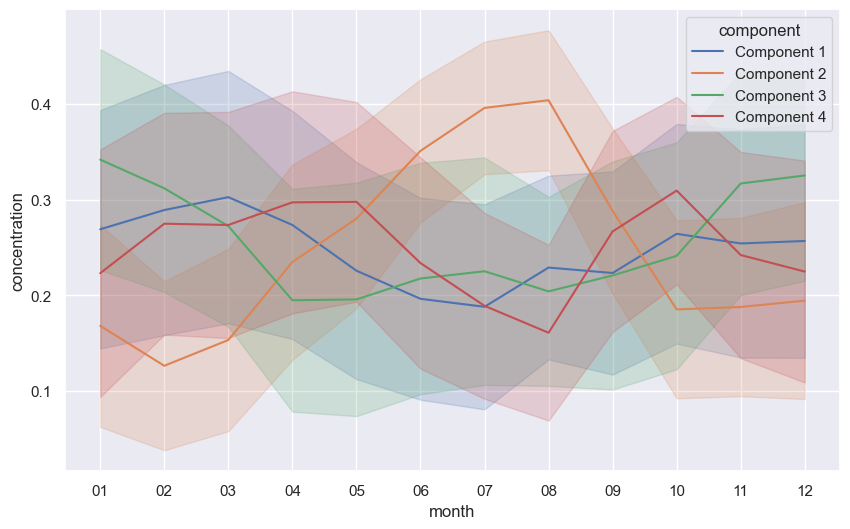

In [62]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
    errorbar='sd'
)

___

# TESTS

In [136]:
n_components_list = [3, 4]

for n_components in n_components_list:

    W_init = initialize_W(X, n_components)
    H_init = np.ones((n_components, p)) / p

    WH_init = np.dot(W_init, H_init)

    # Load the arrays from the .npz file
    data = np.load(f'data/nmf_results/uniform_{n_components}comp.npz')

    iterations = data['iterations']
    H_results = data['H_results'][..., iterations > 100]
    W_results = data['W_results'][..., iterations > 100]

    random_obs = random.randint(0, W_results.shape[2]-1)

    W_random = W_results[..., random_obs]
    H_random = H_results[..., random_obs]

    WH_random = np.dot(W_random, H_random)

    X_fpca = pd.read_csv(f'data/daily_curves_reconstructed_{n_components}PCs.csv', index_col=0)

    # Compute the Frobenius norm between X and the product W_init * H_init
    frobenius_norm_init = np.linalg.norm(X - WH_init, 'fro')
    frobenius_norm_final = np.linalg.norm(X - WH_random, 'fro')
    frobenius_norm_fpca = np.linalg.norm(X - X_fpca, 'fro')

    print(f'### {n_components} components ###')
    print("Frobenius Norm of the initial residual matrix:", frobenius_norm_init)
    print("Frobenius Norm of the final residual matrix:", frobenius_norm_final)
    print("Frobenius Norm of the FPCA residual matrix:", frobenius_norm_fpca)
    print('\n')

### 3 components ###
Frobenius Norm of the initial residual matrix: 3.7358385772724887
Frobenius Norm of the final residual matrix: 0.949199529377695
Frobenius Norm of the FPCA residual matrix: 0.7711263023212324


### 4 components ###
Frobenius Norm of the initial residual matrix: 3.7358385772724887
Frobenius Norm of the final residual matrix: 0.7607376211325353
Frobenius Norm of the FPCA residual matrix: 0.6634465209563668




In [36]:
errors[644]

0.6540102320810631

In [37]:
pd.Series(errors).quantile(np.linspace(0, 1, 21))

0.00    0.652081
0.05    0.653201
0.10    0.653387
0.15    0.653528
0.20    0.653644
0.25    0.653732
0.30    0.653810
0.35    0.653886
0.40    0.653961
0.45    0.654024
0.50    0.654114
0.55    0.654191
0.60    0.654272
0.65    0.654357
0.70    0.654444
0.75    0.654533
0.80    0.654648
0.85    0.654759
0.90    0.654923
0.95    0.655146
1.00    0.756661
dtype: float64

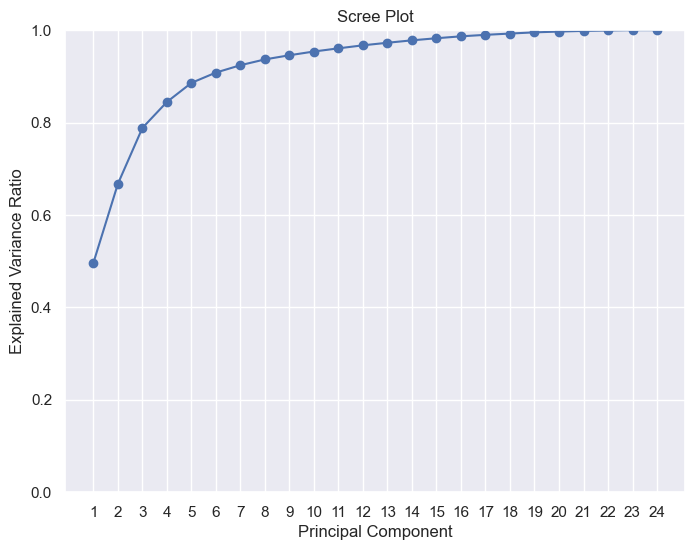

In [74]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
# plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, pca.n_components_ + 1))
plt.ylim((0,1))
plt.grid(True)
plt.show()

In [75]:
np.cumsum(pca.explained_variance_ratio_)

array([0.49630093, 0.66741324, 0.78837141, 0.84461045, 0.88591071,
       0.90821743, 0.92415001, 0.93673463, 0.94572021, 0.95382268,
       0.96067938, 0.96721481, 0.97276266, 0.97799972, 0.98254862,
       0.98667156, 0.98989461, 0.99267498, 0.99526384, 0.99697613,
       0.99841413, 0.99930394, 1.        , 1.        ])

In [57]:
# Perform PCA
pca = PCA(n_components='mle')
X_pca = pca.fit_transform(X)

In [58]:
pca.n_components_

23